
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 残差ネットワーク (ResNet) と ResNeXt

 :ラベル: `sec_resnet`

より深いネットワークを設計するにつれて、レイヤーを追加することでネットワークの複雑さと表現力がどのように高まるかを理解することが不可欠になります。さらに重要なのは、レイヤーを追加することでネットワークが異なるだけでなく、厳密に表現力が高まるネットワークを設計できることです。ある程度進歩するには、少し数学が必要です。


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## 関数クラス

特定のネットワーク アーキテクチャ (学習率やその他のハイパーパラメーター設定とともに) が到達できる関数のクラスである $\mathcal{F}$ について考えてみましょう。つまり、すべての $f \in \mathcal{F}$ に対して、適切なデータセットでのトレーニングを通じて取得できる何らかのパラメータのセット (重みやバイアスなど) が存在します。 $f^ *$ が本当に見つけたい「真実」関数であると仮定しましょう。 $\mathcal{F}$ にある場合、状態は良好ですが、通常はそれほど幸運ではありません。代わりに、$\mathcal{F}$ 内で最善の策である $f^ _\mathcal{F}$ を見つけようとします*。たとえば、特徴 $\mathbf{X}$ とラベル $\mathbf{y}$ を持つデータセットがあるとすると、次の最適化問題を解くことでそれを見つけようとします。

 $$f^*_\mathcal{F} \stackrel{\mathrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \ text{ subject to } f \in \mathcal{F}.$$

正則化 :cite: `tikhonov1977solutions,morozov2012methods` $\mathcal{F}$ の複雑さを制御し、一貫性を達成できることがわかっているため、一般にトレーニング データのサイズが大きいほど $f^ *_\mathcal{F}$ が向上します。別の、より強力なアーキテクチャ $\mathcal{F}&#39;$ を設計すれば、より良い結果が得られるはずだと考えるのは当然です。言い換えれば、$f^* *{\mathcal{F}&#39;}$ は $f^* {\mathcal{F}}$ よりも「優れている」と*予想されます。ただし、 $\mathcal{F} \not\subseteq \mathcal{F}&#39;$ の場合、これが起こるという保証はありません。実際、$f^ *_{\mathcal{F}&#39;}$ はさらに悪い可能性があります。 :numref: `fig_functionclasses`で示されているように、入れ子になっていない関数クラスの場合、より大きな関数クラスが必ずしも「真実」の関数 $f^ $ に近づくとは限りません*。たとえば、 :numref: `fig_functionclasses`の左側では、 $\mathcal{F}_3$*は $\mathcal{F}_1$ よりも $f^ $ に近いですが、 $\mathcal{F}_6$ は離れていきます。複雑さをさらに増やすことで $f^ $ からの距離が縮まるという保証はありません*。 $\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$ が :numref: `fig_functionclasses`の右側にあるネストされた関数クラスを使用すると、ネストされていない関数クラスによる前述の問題を回避できます。 

![](http://d2l.ai/_images/functionclasses.svg) :label: `fig_functionclasses`

したがって、より大きな関数クラスに小さな関数クラスが含まれている場合にのみ、関数クラスを増やすことでネットワークの表現力が厳密に向上することが保証されます。ディープ ニューラル ネットワークの場合、新しく追加した層を恒等関数 $f(\mathbf{x}) = \mathbf{x}$ に学習させることができれば、新しいモデルは元のモデルと同じくらい効果的になります。新しいモデルはトレーニング データセットに適合するためのより適切なソリューションを取得する可能性があるため、追加されたレイヤーによりトレーニング エラーを削減しやすくなる可能性があります。

これは、:citet: `He.Zhang.Ren.ea.2016`非常に深いコンピューター ビジョン モデルに取り組むときに検討した問題です。彼らが提案した*残差ネットワーク*( *ResNet* ) の中心には、追加の層ごとに要素の 1 つとして恒等関数をより簡単に含めるべきであるという考えがあります。これらの考慮事項はかなり奥深いものですが、驚くほど単純な解決策である*残差ブロック*につながりました。この設計により、ResNet は 2015 年の ImageNet Large Scale Visual Recognition Challenge で優勝しました。この設計は、ディープ ニューラル ネットワークの構築方法に大きな影響を与えました。たとえば、残差ブロックはリカレント ネットワークに追加されました:cite: `prakash2016neural,kim2017residual` 。同様に、Transformers :cite: `Vaswani.Shazeer.Parmar.ea.2017`は、それらを使用してネットワークの多くの層を効率的に積み重ねます。これはグラフ ニューラル ネットワークでも使用されています (cite: `Kipf.Welling.2016` )。また、基本概念としてコンピューター ビジョンでも広く使用されています (cite: `Redmon.Farhadi.2018,Ren.He.Girshick.ea.2015` )。残差ネットワークは、恒等関数に関する洗練されたパラメータ化がないにもかかわらず、動機の一部を共有する高速道路ネットワーク :cite: `srivastava2015highway`よりも古いものであることに注意してください。

##  (**残りのブロック**)

 :label: `subsec_residual-blks`

 :numref: `fig_residual_block`に示すように、ニューラル ネットワークのローカル部分に焦点を当ててみましょう。入力を $\mathbf{x}$ で表します。学習によって取得したい基本的なマッピングは $f(\mathbf{x})$ であり、上部の活性化関数への入力として使用されると仮定します。左側の点線ボックス内の部分は、マッピング $f(\mathbf{x})$ を直接学習する必要があります。右側の点線ボックス内の部分は、*残差マッピング*$g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$ を学習する必要があります。これは、残差ブロックの学習方法です。その名前の由来となっています。恒等マッピング $f(\mathbf{x}) = \mathbf{x}$ が目的の基礎となるマッピングである場合、残差マッピングは $g(\mathbf{x}) = 0$ となり、学習が容易になります。 : 点線のボックス内の上部の重み層 (完全結合層や畳み込み層など) の重みとバイアスをゼロにプッシュするだけで済みます。右の図は、ResNet の*残差ブロック*を示しています。ここで、レイヤー入力 $\mathbf{x}$ を加算演算子に運ぶ実線は、*残差接続*(または*ショートカット接続*) と呼ばれます。残差ブロックを使用すると、入力は層間の残差接続を通じてより高速に前方伝播できます。実際、残差ブロックはマルチブランチ Inception ブロックの特殊なケースと考えることができます。このブロックには 2 つのブランチがあり、そのうちの 1 つはアイデンティティ マッピングです。 

![](../img/residual-block.svg) :label: `fig_residual_block`

 ResNet は、VGG の $3\times 3$ の畳み込み層設計を完全に従っています。残差ブロックには、同じ数の出力チャネルを持つ 2 つの $3\times 3$ 畳み込み層があります。各畳み込み層の後には、バッチ正規化層と ReLU 活性化関数が続きます。次に、これら 2 つの畳み込み演算をスキップし、最後の ReLU 活性化関数の直前に入力を追加します。この種の設計では、2 つの畳み込み層の出力が加算できるように、入力と同じ形状である必要があります。チャネル数を変更したい場合は、追加の $1\times 1$ 畳み込み層を導入して、入力を加算演算に必要な形状に変換する必要があります。以下のコードを見てみましょう。


In [2]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


このコードは 2 種類のネットワークを生成します。1 つは`use_1x1conv=False`の場合に ReLU 非線形性を適用する前に入力を出力に追加するもの、もう 1 つは追加する前に $1 \times 1$ 畳み込みによってチャネルと解像度を調整するものです。 :numref: `fig_resnet_block`これを示しています。 

![](../img/resnet-block.svg) :label: `fig_resnet_block`

ここで、$1 \times 1$ 畳み込みが必要ない [**入力と出力が同じ形状である状況**] を見てみましょう。


In [3]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])


[**出力チャンネルの数を増やしながら、出力の高さと幅を半分にする**] オプションもあります。この場合、 `use_1x1conv=True`を介して $1 \times 1$ 畳み込みを使用します。これは、各 ResNet ブロックの開始時に`strides=2`を介して空間次元を削減するのに便利です。


In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])


## [ **ResNet モデル**]

 ResNet の最初の 2 つの層は、前に説明した GoogLeNet の層と同じです。64 個の出力チャネルと 2 のストライドを持つ $7\times 7$ の畳み込み層の後に、ストライドは 2 です。違いは、ResNet の各畳み込み層の後に追加されるバッチ正規化層です。


In [5]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


GoogLeNet は、Inception ブロックで構成される 4 つのモジュールを使用します。ただし、ResNet は残差ブロックで構成される 4 つのモジュールを使用し、それぞれが同じ数の出力チャネルを持つ複数の残差ブロックを使用します。最初のモジュールのチャンネル数は入力チャンネルの数と同じです。ストライド 2 の max-pooling 層がすでに使用されているため、高さと幅を減らす必要はありません。後続の各モジュールの最初の残差ブロックでは、前のモジュールと比較してチャネル数が 2 倍になり、高さと幅が半分になります。


In [6]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)


次に、すべてのモジュールを ResNet に追加します。ここでは、モジュールごとに 2 つの残差ブロックが使用されます。最後に、GoogLeNet と同様に、グローバル平均プーリング層を追加し、その後に全結合層の出力を追加します。


In [7]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)


各モジュールには 4 つの畳み込み層があります ($1\times 1$ 畳み込み層を除く)。最初の $7\times 7$ 畳み込み層と最後の全結合層を合わせると、合計 18 層になります。したがって、このモデルは一般に ResNet-18 として知られています。モジュール内でさまざまな数のチャネルと残差ブロックを構成することで、より深い 152 層の ResNet-152 など、さまざまな ResNet モデルを作成できます。 ResNet の主なアーキテクチャは GoogLeNet と似ていますが、ResNet の構造はより単純で変更が容易です。これらすべての要因により、ResNet が急速かつ広範囲に使用されるようになりました。 :numref: `fig_resnet18`完全な ResNet-18 を示しています。

![](../img/resnet18-90.svg) :ラベル: `fig_resnet18`

 ResNet をトレーニングする前に、[ **ResNet のさまざまなモジュール間で入力形状がどのように変化するかを観察**] してみましょう。これまでのすべてのアーキテクチャと同様に、グローバル平均プーリング層がすべての機能を集約する時点まで、チャネル数が増加する一方で、解像度は低下します。


In [8]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

In [9]:
ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])


Sequential output shape:	 torch.Size([1, 64, 24, 24])


Sequential output shape:	 torch.Size([1, 128, 12, 12])


Sequential output shape:	 torch.Size([1, 256, 6, 6])


Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])



## 【**トレーニング**】

以前と同様に、Fashion-MNIST データセットで ResNet をトレーニングします。 ResNet は非常に強力で柔軟なアーキテクチャです。トレーニング損失と検証損失をキャプチャしたプロットは、両方のグラフ間に大きなギャップがあり、トレーニング損失が大幅に低いことを示しています。この柔軟性のネットワークの場合、より多くのトレーニング データがギャップを埋めて精度を向上させる上で大きなメリットをもたらします。


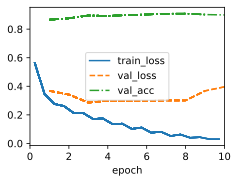

In [10]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)


## レスネクスト

:label: `subsec_resnext`

 ResNet の設計で遭遇する課題の 1 つは、特定のブロック内の非線形性と次元性の間のトレードオフです。つまり、層の数を増やすか、畳み込みの幅を増やすことによって、より多くの非線形性を追加できます。別の戦略は、ブロック間で情報を伝送できるチャネルの数を増やすことです。残念ながら、後者には二次ペナルティが伴います。これは、$c_i$ チャネルの取り込みと $c_o$ チャネルの放出の計算コストが $\mathcal{O}(c_i \cdot c_o)$ に比例するためです (:numref: `sec_channels`の議論を参照してください) ）。

 :numref: `fig_inception`の Inception ブロックからインスピレーションを得ることができます。このブロックには、ブロック内を個別のグループで流れる情報が含まれています。複数の独立したグループのアイデアを :numref: `fig_resnet_block`の ResNet ブロックに適用することで、 ResNeXt :cite: `Xie.Girshick.Dollar.ea.2017`の設計が生まれました。 Inception のさまざまな変換とは異なり、ResNeXt はすべてのブランチで*同じ*変換を採用するため、各ブランチを手動で調整する必要性が最小限に抑えられます。 

![](../img/resnext-block.svg) :label: `fig_resnext_block`

 $c_i$ から $c_o$ チャネルへの畳み込みを、サイズ $c_i/g$ の $g$ グループの 1 つに分割し、サイズ $c_o/g$ の $g$ 出力を生成することを、まさに適切に、*グループ化畳み込み*と呼びます。計算コストは​​ (比例して) $\mathcal{O}(c_i \cdot c_o)$ から $\mathcal{O}(g \cdot (c_i/g) \cdot (c_o/g)) = \mathcal{ O}(c_i \cdot c_o / g)$、つまり $g$ 倍高速です。さらに良いことに、出力の生成に必要なパラメータの数も $c_i \times c_o$ 行列から、サイズ $(c_i/g) \times (c_o/g)$ の $g$ 小さい行列に減ります。 g$ 倍の削減。以下では、$c_i$ と $c_o$ の両方が $g$ で割り切れると仮定します。

この設計の唯一の課題は、$g$ グループ間で情報が交換されないことです。 :numref: `fig_resnext_block`の ResNeXt ブロックは、これを 2 つの方法で修正します。 $3 \times 3$ カーネルによるグループ化された畳み込みが 2 つの $1 \times 1$ 畳み込みの間に挟まれます。 2 つ目は、チャネル数を元に戻すという 2 つの役割を果たします。利点は、$1 \times 1$ カーネルに対して $\mathcal{O}(c \cdot b)$ コストを支払うだけで、$\mathcal{O}(b^2 / g)$ コストで済むことです。 $3 \times 3$ カーネルの場合。 :numref: `subsec_residual-blks`の残差ブロック実装と同様に、残差接続は $1 \times 1$ 畳み込みによって置き換えられます (したがって一般化されます)。

 :numref: `fig_resnext_block`の右の図は、結果として得られるネットワーク ブロックのより簡潔な概要を示しています。また、 :numref: `sec_cnn-design`での汎用の最新 CNN の設計でも重要な役割を果たします。グループ化された畳み込みのアイデアは AlexNet の実装にまで遡ることに注意してください:cite: `Krizhevsky.Sutskever.Hinton.2012` 。メモリが限られている 2 つの GPU にネットワークを分散する場合、実装では各 GPU が独自のチャネルとして扱われ、悪影響はありませんでした。

 `ResNeXtBlock`クラスの次の実装は、引数`groups` ($g$) と、中間 (ボトルネック) チャネル`bot_channels` ($b$) を受け取ります。最後に、表現の高さと幅を減らす必要がある場合は、 `use_1x1conv=True, strides=2`を設定して $2$ のストライドを追加します。


In [11]:
class ResNeXtBlock(nn.Module):  #@save
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)


その使用方法は、前に説明した`ResNetBlock`の使用方法と完全に似ています。たとえば、( `use_1x1conv=False, strides=1` ) を使用する場合、入力と出力は同じ形状になります。あるいは、 `use_1x1conv=True, strides=2`と設定すると、出力の高さと幅が半分になります。


In [12]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

torch.Size([4, 32, 96, 96])


## 要約と考察

ネストされた関数クラスは、容量を追加するときに微妙に*異なる*関数クラスを取得するのではなく、厳密により*強力な関数*を取得できるため、望ましいものです。これを実現する 1 つの方法は、追加のレイヤーが入力を出力に単純に通過できるようにすることです。残りの接続によりこれが可能になります。結果として、これにより帰納バイアスが $f(\mathbf{x}) = 0$ の形式の単純な関数から $f(\mathbf{x}) = \mathbf{x}$ のような単純な関数に変更されます。

残差マッピングは、重み層のパラメーターをゼロにプッシュするなど、恒等関数をより簡単に学習できます。残差ブロックを持たせることで、効果的な*ディープ*ニューラル ネットワークをトレーニングできます。入力は、レイヤー間の残りの接続を通じてより高速に前方伝播できます。結果として、より深いネットワークを訓練できるようになります。たとえば、元の ResNet 論文 :cite: `He.Zhang.Ren.ea.2016`では、最大 152 層が許可されていました。残差ネットワークのもう 1 つの利点は、トレーニング プロセス*中に*恒等関数として初期化された層を追加できることです。結局のところ、レイヤーのデフォルトの動作は、データを変更せずに通過させることです。これにより、場合によっては非常に大規模なネットワークのトレーニングが高速化される可能性があります。

残留接続の前に、100 層を超える高速道路ネットワークを効果的に訓練するために、ゲート ユニットを備えたバイパス パスが導入されました :cite: `srivastava2015highway` 。 ID 関数をバイパス パスとして使用することで、ResNet は複数のコンピューター ビジョン タスクで非常に優れたパフォーマンスを発揮しました。残留接続は、畳み込み的性質と逐次的性質の両方において、その後のディープ ニューラル ネットワークの設計に大きな影響を与えました。後で紹介するように、Transformer アーキテクチャ :cite: `Vaswani.Shazeer.Parmar.ea.2017`は残差接続を (他の設計選択肢とともに) 採用しており、言語、視覚、音声、強化学習などの多様な領域に普及しています。

 ResNeXt は、畳み込みニューラル ネットワークの設計が時間の経過とともにどのように進化したかを示す一例です。計算をより倹約し、アクティベーションのサイズ (チャネル数) とトレードオフすることで、より高速でより正確なネットワークを低コストで実現できます。 。グループ化された畳み込みを表示する別の方法は、畳み込みの重みのブロック対角行列を考えることです。ネットワークをより効率的にするためのこのような「トリック」がかなりの数あることに注意してください。たとえば、ShiftNet :cite: `wu2018shift` 、シフトされたアクティベーションをチャネルに追加するだけで、$3 \times 3$ の畳み込みの効果を模倣し、今回は計算コストをかけずに関数の複雑性を高めます。

これまで説明してきた設計の共通の特徴は、ネットワーク設計がかなり手動であり、「適切な」ネットワーク ハイパーパラメータを見つけるには主に設計者の創意工夫に依存していることです。明らかに実現可能ではありますが、人的時間の面で非常にコストがかかり、いかなる意味においても結果が最適であるという保証はありません。 :numref: `sec_cnn-design`では、より自動化された方法で高品質のネットワークを取得するためのいくつかの戦略について説明します。特に、RegNetX/Y モデルにつながった*ネットワーク設計空間*の概念を確認します (cite: `Radosavovic.Kosaraju.Girshick.ea.2020` )。

## 演習
1. :numref: `fig_inception`の Inception ブロックと残差ブロックの主な違いは何ですか?計算、精度、記述できる関数のクラスの点で、それらはどのように比較されるのでしょうか?
1. ネットワークのさまざまなバリアントを実装するには、ResNet 論文 :cite: `He.Zhang.Ren.ea.2016`の表 1 を参照してください。
1. より深いネットワークの場合、ResNet はモデルの複雑さを軽減するために「ボトルネック」アーキテクチャを導入します。それを実装してみてください。
1.  ResNet のその後のバージョンでは、作成者は「畳み込み、バッチ正規化、およびアクティブ化」構造を「バッチ正規化、アクティブ化、および畳み込み」構造に変更しました。この改善は自分で行ってください。詳細については、:citet: `He.Zhang.Ren.ea.2016*1`の図 1 を参照してください。
1. 関数クラスがネストされている場合でも、関数の複雑さを際限なく増やすことができないのはなぜでしょうか?



[ディスカッション](https://discuss.d2l.ai/t/86)
